In [99]:
# Install required packages.
import os
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam

from torch_geometric.nn import GCNConv, GraphConv, GATConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_batch

from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function for visualization.
import matplotlib.pyplot as plt
import numpy as np

2.4.1+cu121


## Utils

In [100]:
def parse_cell_txt(file_path):
    cells = []  # 用于存储解析后的数据

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for i in range(0, len(lines), 3):
        # 每三行表示一个cell的数据
        center_line = lines[i].strip()
        cell_neighbors_line = lines[i + 1].strip()
        node_neighbors_line = lines[i + 2].strip()

        # 解析中心位置和半径
        center_data = list(map(float, center_line.split()))
        cell_center = {
            "x": center_data[0],
            "y": center_data[1],
            "z": center_data[2],
            "radius": center_data[3]
        }

        # 解析cell的连接关系
        cell_neighbors = list(map(int, cell_neighbors_line.split()))

        # 解析node的连接关系
        node_neighbors = list(map(int, node_neighbors_line.split()))

        # 组合到一个字典
        cell = {
            "cell_center": cell_center,
            "cell_neighbors": cell_neighbors,
            "node_neighbors": node_neighbors
        }

        # 添加到结果列表
        cells.append(cell)

    return cells

def sort_nodes_and_edges(node_features_np: np.ndarray, edges_np: np.ndarray):
    """
    对节点按 (r, x, phi) 排序，并更新边的索引。

    Args:
        node_features (numpy.ndarray): 节点特征，形状为 [num_nodes, feature_dim]。
        edges (numpy.ndarray): 边列表，形状为 [2, num_edges]。

    Returns:
        sorted_node_features: 排序后的节点特征 (torch.Tensor)。
        sorted_edges: 排序后的边索引 (torch.Tensor)。
    """
    # 提取 x, y, z 坐标
    x = node_features_np[:, 0]
    y = node_features_np[:, 1]
    z = node_features_np[:, 2]

    # 计算球坐标
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(z, y) % (2 * np.pi)

    # 构造球坐标用于排序
    spherical_coords = np.stack((r, x, phi), axis=1)

    # 按球坐标排序 (r, x, phi)
    sorted_order = np.lexsort((spherical_coords[:, 2], spherical_coords[:, 1], spherical_coords[:, 0]))
    sorted_node_features_np = node_features_np[sorted_order]

    # 创建从原始索引到排序后索引的映射
    index_mapping = {original_idx: sorted_idx for sorted_idx, original_idx in enumerate(sorted_order)}

    # 更新边索引
    sorted_edges = []
    for edge in edges_np:  # 遍历每条边
        node1, node2 = edge
        sorted_node1 = index_mapping[node1]
        sorted_node2 = index_mapping[node2]
        sorted_edges.append([sorted_node1, sorted_node2])

    return sorted_node_features_np, sorted_edges

def get_gnn_dataset(cells, device):
    """
    根据解析后的cells数据构建GNN数据集
    Args:
        cells (list): 包含每个cell的中心和连接关系的字典列表
    Returns:
        torch_geometric.data.Data: 包含节点特征和边信息的图数据
    """
    # 节点特征: 使用cell_center (x, y, z, radius)
    node_features = []
    edges = []

    for node_id, cell in enumerate(cells):
        # 添加节点特征
        center = cell["cell_center"]
        node_features.append([center["x"], center["y"], center["z"], center["radius"]])

        # 添加边: 从当前节点到其邻居
        for neighbor_id in cell["cell_neighbors"]:
            # 添加双向边
            edges.append((node_id, neighbor_id))
            edges.append((neighbor_id, node_id))
    
    # 转换为numpy数组
    node_features_np = np.array(node_features)
    edges_np = np.array(edges)
    edges_np = np.unique(edges_np, axis=0)  # 去重

    # 对节点和边进行排序
    sorted_node_features_np, sorted_edges_np = sort_nodes_and_edges(node_features_np, edges_np)

    # 转换为torch.Tensor
    node_features_tensor = torch.tensor(sorted_node_features_np, dtype=torch.float).to(device)
    edges_tensor = torch.tensor(sorted_edges_np, dtype=torch.long).t().contiguous().to(device)

    # 创建图数据
    data = Data(x=node_features_tensor[:,3:], edge_index=edges_tensor)
    data.pos = node_features_tensor[:,0:3]

    return data

def load_target_data(filename, device):
    """
    Loads ray data from parameter file.
    """
    datafile = filename

    parameters = torch.load(filename, map_location=device) 
    w_logits = parameters['w_logits']
    theta_phi = parameters['theta_phi']
    log_kappa = parameters['log_kappa']
    theta = theta_phi[:log_kappa.size(0)]
    phi = theta_phi[log_kappa.size(0):]
    indices = np.lexsort((-phi.cpu().numpy(), -theta.cpu().numpy(), -log_kappa.cpu().numpy(), -w_logits.cpu().numpy()))
    sorted_indices = torch.tensor(indices)
    target_data = torch.stack([w_logits,log_kappa,theta,phi], dim=1)
    target_data = target_data[sorted_indices,:]
    target_data = torch.flatten(target_data)
    return target_data.to(device)
    
# 多重 von Mises-Fisher 分布函数
def multi_vmf(weights, axes, kappas, w):
    # Ensure kappas are non-negative for stability
    kappas = torch.clamp(kappas, min=1e-10, max=1e5)

    # Define thresholds for approximations
    large_kappa_threshold = 1e5  # Threshold for considering kappa as "large"
    small_kappa_threshold = 1e-3  # Threshold for considering kappa as "small"

    # Approximate normalization constant for large and small kappa values


    norm_const = torch.where(
        kappas > large_kappa_threshold,
        kappas / (2 * math.pi),  # Approximation for large kappa
        kappas / (2 * math.pi * (1-torch.exp(-2*kappas)))
    )
    # norm_const = kappas / (4 * math.pi * (1-torch.exp(-2*kappas)))

    # Compute dot products between input w and the axes of the spheres (unit vectors)
    dot_products = torch.matmul(w, axes.transpose(0, 1))-1  # Shape: (data_sizes, num_spheres)

    # Compute the weighted von Mises-Fisher pdf values
    weighted_exps = weights * norm_const * torch.exp(kappas * dot_products)  # Shape: (data_sizes, num_spheres)
    q = torch.sum(weighted_exps, dim=-1)  # Shape: (data_sizes,)
    q = torch.clamp(q, min=1e-10, max=1e10)  # Further clamping to avoid extreme values
    return q

def plot_outputs_3d(references, predictions, sizes, save_path=None):
    # 定义 z 和 phi 的范围
    z_min, z_max = -1, 1
    phi_min, phi_max = -np.pi, np.pi

    # 创建用于 3D 绘图的网格
    z_in = np.linspace(z_min, z_max, sizes[0])
    phi_in = np.linspace(phi_min, phi_max, sizes[1])

    Z, Phi = np.meshgrid(z_in, phi_in, indexing='ij')

    target_img = references
    predict_img = predictions

    # 确保输入数据的形状与网格匹配
    if predict_img.shape != Z.shape:
        predict_img = predict_img.reshape(Z.shape)
    if target_img is not None and target_img.shape != Z.shape:
        target_img = target_img.reshape(Z.shape)

    # 设置用于 3D 可视化的子图
    if target_img is not None and np.sum(target_img) > 0:
        fig = plt.figure(figsize=(14, 6))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    else:
        fig = plt.figure(figsize=(10, 6))
        ax1 = fig.add_subplot(1, 1, 1, projection='3d')

    # 绘制预测数据的 3D 曲面
    ax1.plot_surface(Z, Phi, predict_img, rstride=1, cstride=1, cmap='rainbow')
    ax1.set_title('Prediction')
    ax1.set_xlabel('Z')
    ax1.set_ylabel('Phi')
    ax1.set_zlabel('Value')

    # 如果有参考数据，绘制其 3D 曲面
    if target_img is not None and np.sum(target_img) > 0:
        ax2.plot_surface(Z, Phi, target_img, rstride=1, cstride=1, cmap='rainbow')
        ax2.set_title('Reference')
        ax2.set_xlabel('Z')
        ax2.set_ylabel('Phi')
        ax2.set_zlabel('Value')

    # 显示图形
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()
    

def get_gridX(sizes):
    i_idx = torch.arange(sizes[0], dtype=torch.float, device=device) / sizes[0]
    j_idx = torch.arange(sizes[1], dtype=torch.float, device=device) / sizes[1]
    i_grid, j_grid = torch.meshgrid(i_idx, j_idx)
    pos_x = i_grid * 2 - 1
    pos_phi = (j_grid * 2 - 1) * np.pi
    pos_r = torch.sqrt(1 - pos_x**2)
    pos_y = pos_r * torch.cos(pos_phi)
    pos_z = pos_r * torch.sin(pos_phi)
    X = torch.stack((pos_x, pos_y, pos_z), dim=-1).reshape(-1, 3).to(device)
    return X


# 加载 ray 数据的函数
def load_rawdata(filename, sizes, device, verbose=False):
    X = get_gridX(sizes)

    rawdata = np.fromfile(filename, dtype=np.float32)
    rawdata = rawdata.reshape(-1, 4)
    # print(rawdata.shape)
    x = rawdata[:,0]
    # print(np.max(data[:,1]))
    phi = rawdata[:,1]-np.pi
    r = np.sqrt(1 - x**2)
    y = r * np.cos(phi)
    z = r * np.sin(phi)


    # 创建网格分布
    x_edges = np.linspace(-1, 1, sizes[0]+1)  
    phi_edges = np.linspace(-np.pi, np.pi, sizes[1]+1)

    # 统计 (X, φ) 分布
    H, _, _ = np.histogram2d(x, phi, bins=[x_edges, phi_edges])
    ray_data = torch.tensor(H, dtype=torch.float32, device=device).reshape(-1, 1)
    if ray_data.shape[0] != sizes[0] * sizes[1]:
        print("Error: ray data shape mismatch!")
        exit(1)
    area = 4 * math.pi / (ray_data.shape[0])
    ray_data = ray_data / torch.sum(ray_data) / area
    

    raw_X = np.column_stack((x, y, z))
    raw_num = min(4096, raw_X.shape[0])
    raw_X = raw_X[:raw_num, :]

    # 将数据转换为张量
    raw_data = torch.tensor(raw_X, dtype=torch.float32, device=device)
    
    if verbose:
        print("X Mesh shape:", X.shape)
        print("ray data shape:", ray_data.shape)
        print("raw data shape:", raw_data.shape)
    return raw_data, ray_data, X


def generate_filenames(base_path, target_file, num_files):
    """生成文件路径列表"""
    return [os.path.join(base_path, f"{i}", target_file) for i in range(1, num_files + 1)]

def smooth_curve(values, smoothing_factor=0.9):
    smoothed_values = []
    last = values[0]
    for value in values:
        smoothed_value = last * smoothing_factor + (1 - smoothing_factor) * value
        smoothed_values.append(smoothed_value)
        last = smoothed_value
    return smoothed_values

def plot_losses(train_losses, val_losses = None):
    train_losses_smoothed = smooth_curve(train_losses)
    if val_losses is not None:
        val_losses_smoothed = smooth_curve(val_losses)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_smoothed, label="Training Loss (Smoothed)", color="blue")
    if val_losses is not None:
        plt.plot(val_losses_smoothed, label="Validation Loss (Smoothed)", color="red")
    plt.yscale("log")  # Log scale for the y-axis
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.title("Loss (Log Scale with Smoothing)")
    plt.legend()
    plt.show()

## GNN Encoder

In [101]:
import torch
import torch.nn as nn
import math

class PositionalEncoder(nn.Module):
    def __init__(self, L):
        """
        Initializes the PositionalEncoder module.

        Parameters:
        - L (int): Number of frequency components in the encoding.
        """
        super(PositionalEncoder, self).__init__()
        self.L = L

        # Precompute the frequency terms (2^k * pi)
        frequencies = torch.tensor([1 << i for i in range(L)], dtype=torch.float32) * math.pi
        self.register_buffer('frequencies', frequencies)  # Shape: (L,)

    def forward(self, p):
        """
        Computes the positional encoding gamma(p) for a given input p in the range [-1, 1].

        Parameters:
        - p (torch.Tensor): Input tensor of shape (batch_size, dim) with values in the range [-1, 1].

        Returns:
        - torch.Tensor: Positional encoding of shape (batch_size, dim * L).
        """
        # Ensure p is on the same device as frequencies
        # (Not needed since frequencies will be moved with the model)

        # Ensure p has the correct shape to broadcast with frequencies
        p = p.unsqueeze(-1)  # Shape: (batch_size, dim, 1)
        
        # Apply sin transformation only
        sin_encodings = torch.sin(p * self.frequencies)  # Shape: (batch_size, dim, L) 

        return sin_encodings.view(p.size(0), -1)  # Shape: (batch_size, dim * L)


In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# GCN Module with Residual Connections
class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        # GCN Layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.skip1 = nn.Linear(num_features, hidden_channels) if num_features != hidden_channels else nn.Identity()
        self.skip2 = nn.Identity()
        self.skip3 = nn.Identity()

    def forward(self, x, edge_index):
        # First Layer with Skip Connection
        residual = self.skip1(x)
        x = self.conv1(x, edge_index)
        x = F.relu(x + residual)
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Second Layer with Skip Connection
        residual = self.skip2(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x + residual)
        x = F.dropout(x, p=0.3, training=self.training)
        
        # Third Layer with Skip Connection
        residual = self.skip3(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x + residual)
        x = F.dropout(x, p=0.3, training=self.training)
        
        return x

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.conv3.reset_parameters()
        if isinstance(self.skip1, nn.Linear):
            self.skip1.reset_parameters()


In [103]:
from collections import OrderedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

 
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + F.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * torch.pow(x,3))))
    
# Residual Attention Block
class ResidualAttentionBlock(nn.Module):
    def __init__(self, d_model: int, n_head: int):
        super(ResidualAttentionBlock, self).__init__()
        self.attn = nn.MultiheadAttention(d_model, n_head)
        self.ln_1 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(OrderedDict([
            ("c_fc", nn.Linear(d_model, d_model * 4)),
            ("gelu", GELU()),
            ("c_proj", nn.Linear(d_model * 4, d_model))
        ]))
        self.ln_2 = nn.LayerNorm(d_model)

    def attention(self, x: torch.Tensor, key_padding_mask: torch.Tensor = None):
        return self.attn(x, x, x, key_padding_mask=key_padding_mask)[0]

    def forward(self, x: torch.Tensor, key_padding_mask: torch.Tensor = None):
        x = x + self.attention(self.ln_1(x), key_padding_mask=key_padding_mask)
        x = x + self.mlp(self.ln_2(x))
        return x

# Transformer Module
class Transformer(nn.Module):
    def __init__(self, width: int, layers: int, heads: int):
        super(Transformer, self).__init__()
        self.width = width
        self.layers = layers
        self.resblocks = nn.ModuleList([
            ResidualAttentionBlock(width, heads) for _ in range(layers)
        ])

    def forward(self, x: torch.Tensor, key_padding_mask: torch.Tensor = None):
        for block in self.resblocks:
            x = block(x, key_padding_mask=key_padding_mask)
        return x

In [104]:
# GCNTransformer class, mimicking Vision Transformer structure
class GCNTransformer(nn.Module):
    def __init__(
        self,
        num_features: int,
        transformer_width: int,
        transformer_layers: int,
        transformer_heads: int,
        hidden_dim: int,
        output_dim: int,
        embedding_dim: int,  # Number of frequency components for PositionalEncoder
        pos_dim: int,  # Dimension of positional features
        dropout: float = 0.1,
    ):
        super(GCNTransformer, self).__init__()
        self.num_features = num_features
        self.output_dim = output_dim

        # Positional Encoder
        self.positional_encoder = PositionalEncoder(L=embedding_dim)

        # GCN module
        self.gcn = GCN(num_features + embedding_dim*pos_dim, embedding_dim)

        # [CLS] token as a learnable embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, transformer_width))

        # Mapping GCN output to Transformer input dimension
        self.gcn_to_transformer = nn.Linear(embedding_dim*(pos_dim+1), transformer_width)

        # Layer normalization before Transformer
        self.ln_pre = nn.LayerNorm(transformer_width)

        # If positional encoding increases the dimension, adjust the transformer width accordingly
        self.transformer = Transformer(width=transformer_width, layers=transformer_layers, heads=transformer_heads)

        # Layer normalization after Transformer
        self.ln_post = nn.LayerNorm(transformer_width)

        self.decoder = nn.Sequential(
            nn.Linear(transformer_width, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        # Initialize GCN to Transformer mapping
        nn.init.trunc_normal_(self.gcn_to_transformer.weight, std=0.02)
        if self.gcn_to_transformer.bias is not None:
            nn.init.zeros_(self.gcn_to_transformer.bias)
        # Positional Encoder weightare fixed (sinusoidal), no initialization needed

    def forward(self, x, edge_index, p, batch):
        """
        x: [total_num_nodes, num_features]
        edge_index: [2, num_edges]
        p: [total_num_nodes, pos_dim], positional features for each node in the range [-1, 1]
        batch: [total_num_nodes], indicating the graph index each node belongs to
        """

        pos_enc = self.positional_encoder(p)  # [total_num_nodes, embedding_dim * pos_dim]

        x = torch.cat([x, pos_enc], dim=-1)  # [total_num_nodes, num_features + embedding_dim * pos_dim]
        # Extract node features using GCN
        x = self.gcn(x, edge_index)  # [total_num_nodes, embedding_dim]

        x = torch.cat([x, pos_enc], dim=-1) # [total_num_nodes, embedding_dim*(pos_dim+1)]

        # Map to Transformer input dimension
        x = self.gcn_to_transformer(x)  # [total_num_nodes, transformer_width]

        x_dense, mask = to_dense_batch(x, batch)  # x_dense: [batch_size, max_num_nodes, transformer_width]; mask: [batch_size, max_num_nodes]

        batch_size, max_num_nodes, _ = x_dense.size()
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch_size, 1, transformer_width]
        x_dense = torch.cat([cls_tokens, x_dense], dim=1)  # [batch_size, 1 + max_num_nodes, transformer_width]

        # Add True for [CLS] tokens
        cls_mask = torch.ones(batch_size, 1, dtype=torch.bool, device=x.device)
        attention_mask = torch.cat([cls_mask, mask], dim=1)  # [batch_size, 1 + max_num_nodes]

        # Permute to match Transformer input shape (sequence_length, batch_size, embedding_dim)
        x_dense = x_dense.permute(1, 0, 2)  # [1 + max_num_nodes, batch_size, transformer_width]

        # Forward pass through Transformer
        x_transformed = self.transformer(x_dense, key_padding_mask=~attention_mask)  # [1 + max_num_nodes, batch_size, transformer_width]

        # Permute back to (batch_size, sequence_length, embedding_dim)
        x_transformed = x_transformed.permute(1, 0, 2)  # [batch_size, 1 + max_num_nodes, transformer_width]

        # Extract the [CLS] token's features
        cls_features = self.ln_post(x_transformed[:, 0, :])  # [batch_size, transformer_width]

        # Pass through the decoder
        out = self.decoder(cls_features)  # [batch_size, output_dim]

        return out  # [batch_size, output_dim]

    def vmf_param(self, x, edge_index, p, batch):
        """
        计算模型输出的von Mises-Fisher (vMF)分布参数。
        
        参数：
        - x (torch.Tensor): 节点特征矩阵，形状为 [total_num_nodes, num_features]
        - edge_index (torch.Tensor): 边索引，形状为 [2, num_edges]
        - p (torch.Tensor): 位置特征，形状为 [total_num_nodes, pos_dim]，范围为 [-1, 1]
        - batch (torch.Tensor): 批量向量，指示每个节点所属的图，形状为 [total_num_nodes]
        
        返回：
        - weights (torch.Tensor): [batch_size, num_vmf]
        - mus (torch.Tensor): [batch_size, num_vmf, 3]
        - kappas (torch.Tensor): [batch_size, num_vmf]
        """
        with torch.no_grad():
            # 前向传播，获取模型输出
            out = self(x, edge_index, p, batch)  # [batch_size, output_dim]
            
            # 确定批量大小和vMF组件的数量
            batch_size = out.size(0)  # [batch_size]
            output_dim = out.size(1)  # output_dim = num_vmf * 4
            assert output_dim % 4 == 0, "Output dimension must be divisible by 4 for vMF parameters"
            num_vmf = output_dim // 4  # 每个图的vMF组件数量
            
            # 重塑输出为 [batch_size, num_vmf, 4]
            out = out.view(batch_size, num_vmf, 4)  # [batch_size, num_vmf, 4]
            
            # 计算vMF参数
            weights = F.softmax(out[:, :, 0], dim=-1)  # [batch_size, num_vmf]
            kappas = torch.exp(out[:, :, 1])           # [batch_size, num_vmf]
            theta = torch.sigmoid(out[:, :, 2]) * math.pi  # [batch_size, num_vmf]
            phi = torch.sigmoid(out[:, :, 3]) * math.pi * 2  # [batch_size, num_vmf]
            
            # 将球面坐标（theta, phi）转换为笛卡尔坐标（mu向量）
            cos_theta = torch.cos(theta)  # [batch_size, num_vmf]
            sin_theta = torch.sin(theta)  # [batch_size, num_vmf]
            cos_phi = torch.cos(phi)      # [batch_size, num_vmf]
            sin_phi = torch.sin(phi)      # [batch_size, num_vmf]
            
            # 组合mu向量： [batch_size, num_vmf, 3]
            mus = torch.stack(
                (sin_theta * cos_phi, sin_theta * sin_phi, cos_theta),
                dim=-1
            )  # [batch_size, num_vmf, 3]
            
            return weights, mus, kappas



## Loss

In [105]:
def criterion(output, target):
    """
    Computes the mean squared error loss.

    Parameters:
    - output (torch.Tensor): Output tensor of the model.
    - target (torch.Tensor): Target tensor.

    Returns:
    - torch.Tensor: Loss value.
    """
    return F.mse_loss(output, target)

## Data

## Hyper Parameters

In [ ]:
# 基础路径和 foam 名称列表
base_path = "D:\\Github\\datasets\\raw_data"
foam_names = ["foam0", "foam1", "foam2", "foam3", "foam4", "foam5"]
file_num = 14

# 文件名
cell_path = "cells.txt"
param_path = "vmf_parameters.pth"
raw_path = "rawdataNonSpe.bin"

# 网格大小
sizes = [64, 64]
X = get_gridX(sizes)

# 初始化数据集列表
datasets = []
ray_datasets = []

# 遍历所有 foam 文件夹
for foam_name in foam_names:
    folder_path = os.path.join(base_path, foam_name)
    
    # Generate file paths
    graphs_path = generate_filenames(folder_path, cell_path, file_num)
    target_path = generate_filenames(folder_path, param_path, file_num)
    rays_path = generate_filenames(folder_path, raw_path, file_num)
    
    # Load data for each file
    for i in range(file_num):
        # Load graph data
        parsed_cells = parse_cell_txt(graphs_path[i])
        graph_data = get_gnn_dataset(parsed_cells, device)
        
        # Load target data
        target_data = load_target_data(target_path[i], device)
        graph_data.y = target_data.reshape(-1)  # 确保目标数据形状为 [output_dim]
        graph_data.batch = torch.zeros(graph_data.num_nodes, dtype=torch.long, device=device)

        # Load raw data
        _, ray_data, _ = load_rawdata(rays_path[i], sizes, device)
        ray_datasets.append(ray_data)
        
        datasets.append(graph_data)

# Create a DataLoader with the datasets
batch_size = 16  # According to the available GPU memory
data_loader = DataLoader(datasets, batch_size=batch_size, shuffle=True)

In [108]:
# Define hyperparameters
num_features = datasets[0].x.size(1)
# num_features = graph_data.x.size(1)
transformer_width = 256
transformer_layers = 4
transformer_heads = 8
embedding_dim = 64  # Number of frequency components for PositionalEncoder
pos_dim = datasets[0].pos.size(1)
# pos_dim = graph_data.pos.size(1)
dropout = 0.1

hidden_dim = 128
output_dim = 256

num_epochs = 7000
lr = 1e-4

# Initialize the model
gcn_transformer = GCNTransformer(
    num_features=num_features,
    transformer_width=transformer_width,
    transformer_layers=transformer_layers,
    transformer_heads=transformer_heads,
    hidden_dim = hidden_dim,
    output_dim = output_dim,
    embedding_dim=embedding_dim,
    pos_dim=pos_dim,
    dropout=dropout,
).to(device)


optimizer = Adam(gcn_transformer.parameters(), lr=lr)
batch_size = 16  # Adjust based on your system's memory
data_loader = DataLoader(datasets, batch_size=batch_size, shuffle=True)
# Training loop
loss_history = []

In [109]:
def train_model(model, data_loader, optimizer, num_epochs):
    loss_history = []
    with tqdm(total=num_epochs, desc="Training Progress") as pbar:
        for epoch in range(num_epochs):
            total_loss = 0
            count = 0
            # Iterate over pre-loaded data with tqdm for progress visualization
            for batch_data in data_loader:
                batch_data = batch_data.to(device)

                optimizer.zero_grad()

                # Forward pass
                predictions = gcn_transformer(
                    batch_data.x,
                    batch_data.edge_index,
                    batch_data.pos,
                    batch_data.batch
                ).reshape(-1)
                # Compute the loss
                loss = criterion(predictions, batch_data.y)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                count += 1

            average_loss = total_loss/count
            loss_history.append(average_loss)
            pbar.set_postfix({
                'Loss': f"{average_loss:.6f}"
            })
            pbar.update(1)
        tqdm.write("Training complete!")
    return loss_history


In [110]:
train_model(gcn_transformer, data_loader, optimizer, num_epochs)

Training Progress:   0%|          | 28/7000 [00:03<13:12,  8.80it/s, Loss=3.709612]


KeyboardInterrupt: 

In [ ]:

model_save_path = os.path.join(base_path, f"gnn_parameters.pth")
torch.save(gcn_transformer.state_dict(), model_save_path)

## Utils

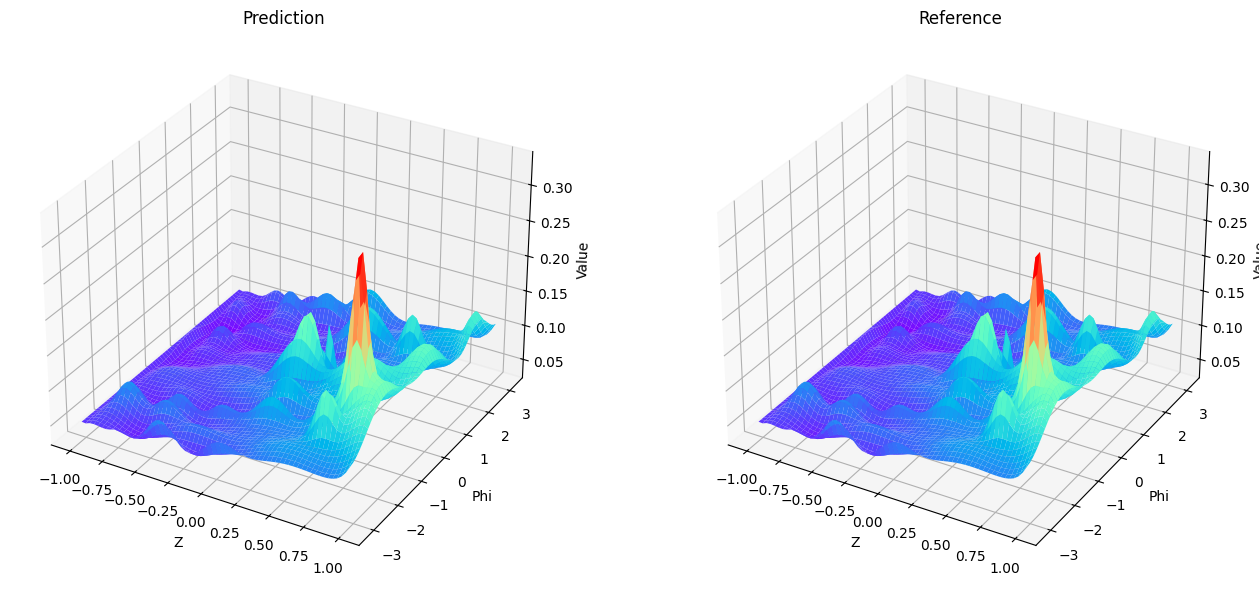

In [ ]:
test_graph_data = datasets[0]
test_ray_data = ray_datasets[0]

def extract_param(vmf_param):
    vmf_param = vmf_param.reshape(-1,4)  
    weights = F.softmax(vmf_param[:,0],dim=-1)
    kappas = torch.exp(vmf_param[:,1])
    theta = torch.sigmoid(vmf_param[:,2])* math.pi 
    phi = torch.sigmoid(vmf_param[:,3])* math.pi * 2
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    cos_phi = torch.cos(phi)
    sin_phi = torch.sin(phi)
    mus = torch.stack((sin_theta * cos_phi, sin_theta * sin_phi, cos_theta), dim=1)
    return weights, mus, kappas



with torch.no_grad():
    weights, mus, kappas = gcn_transformer.vmf_param(test_graph_data.x, test_graph_data.edge_index, test_graph_data.pos, test_graph_data.batch)
    img_predict = multi_vmf(weights.squeeze(), mus.squeeze(), kappas.squeeze(), X).cpu().numpy() 
    img_predict = img_predict.reshape(sizes)

    tgt_w, tgt_m, tgt_k = extract_param(test_graph_data.y)
    img_reference = multi_vmf(tgt_w,tgt_m,tgt_k, X).cpu().numpy()
    img_reference = img_reference.reshape(sizes)

    # img_reference = test_ray_data.cpu().numpy().reshape(sizes[0], sizes[1])
    plot_outputs_3d(img_reference, img_predict, sizes)

In [ ]:

# class GCN(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(num_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         self.conv3 = GCNConv(hidden_channels, hidden_channels)

#     def forward(self, x, edge_index):
#         x_0 = x.clone().detach()

#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)
#         x = self.conv3(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)
        
#         x = torch.cat([x_0, x], dim=-1)
        
#         return x
    
#     def reset_parameters(self):
#         self.conv1.reset_parameters()
#         self.conv2.reset_parameters()
#         self.conv3.reset_parameters()
#         self.lin.reset_parameters()

# class GNN(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels):
#         super(GNN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GraphConv(num_features, hidden_channels)
#         self.conv2 = GraphConv(hidden_channels, hidden_channels)
#         self.conv3 = GraphConv(hidden_channels, hidden_channels)
#         self.lin = Linear(hidden_channels, dataset.num_classes)

#     def forward(self, x, edge_index):
#         x_0 = x.clone().detach()

#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)
#         x = self.conv3(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)

#         x = torch.cat([x_0, x], dim=-1)
        
#         return x

# class GAT(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels, heads=8):
#         super(GAT, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=0.6)
#         self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=0.6)

#     def forward(self, x, edge_index):
#         x_0 = x.clone().detach()

#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.6, training=self.training)
#         x = self.conv2(x, edge_index)

#         x = torch.cat([x_0, x], dim=-1)
        
#         return x
    
#     def reset_parameters(self):
#         self.conv1.reset_parameters()
#         self.conv2.reset_parameters()

# class GraphSAGE(torch.nn.Module):
#     def __init__(self, num_features, hidden_channels):
#         super(GraphSAGE, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = SAGEConv(num_features, hidden_channels)
#         self.conv2 = SAGEConv(hidden_channels, hidden_channels)
#         self.conv3 = SAGEConv(hidden_channels, hidden_channels)

#     def forward(self, x, edge_index):
#         x_0 = x.clone().detach()

#         x = self.conv1(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)
#         x = self.conv2(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)
#         x = self.conv3(x, edge_index)
#         x = x.relu()
#         x = F.dropout(x, p=0.3, training=self.training)

#         x = torch.cat([x_0, x], dim=-1)
        
#         return x
    
#     def reset_parameters(self):
#         self.conv1.reset_parameters()
#         self.conv2.reset_parameters()
#         self.conv3.reset_parameters()